<a href="https://colab.research.google.com/github/wafa-b/Introduction-to-Deep-Learning-with-PyTorch/blob/master/Study%20jam%20challenge/Image_binary_classification_Residential_vs_Industrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir("/content/drive/My Drive/")

In [32]:
!unzip staticmap

Archive:  staticmap.zip
replace staticmap/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [33]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import OrderedDict

from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# choose the training and test datasets
total_data =  datasets.ImageFolder('staticmap', transform=transform)


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.3 #### What portion would you like to allocate for validation?

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data =  datasets.ImageFolder('staticmap/train', transform=transform)
test_data =  datasets.ImageFolder('staticmap/test', transform=transform)


# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [0]:
# specify the image classes
classes = ['Industrial','resedential']

In [37]:
len(train_idx)

1410

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

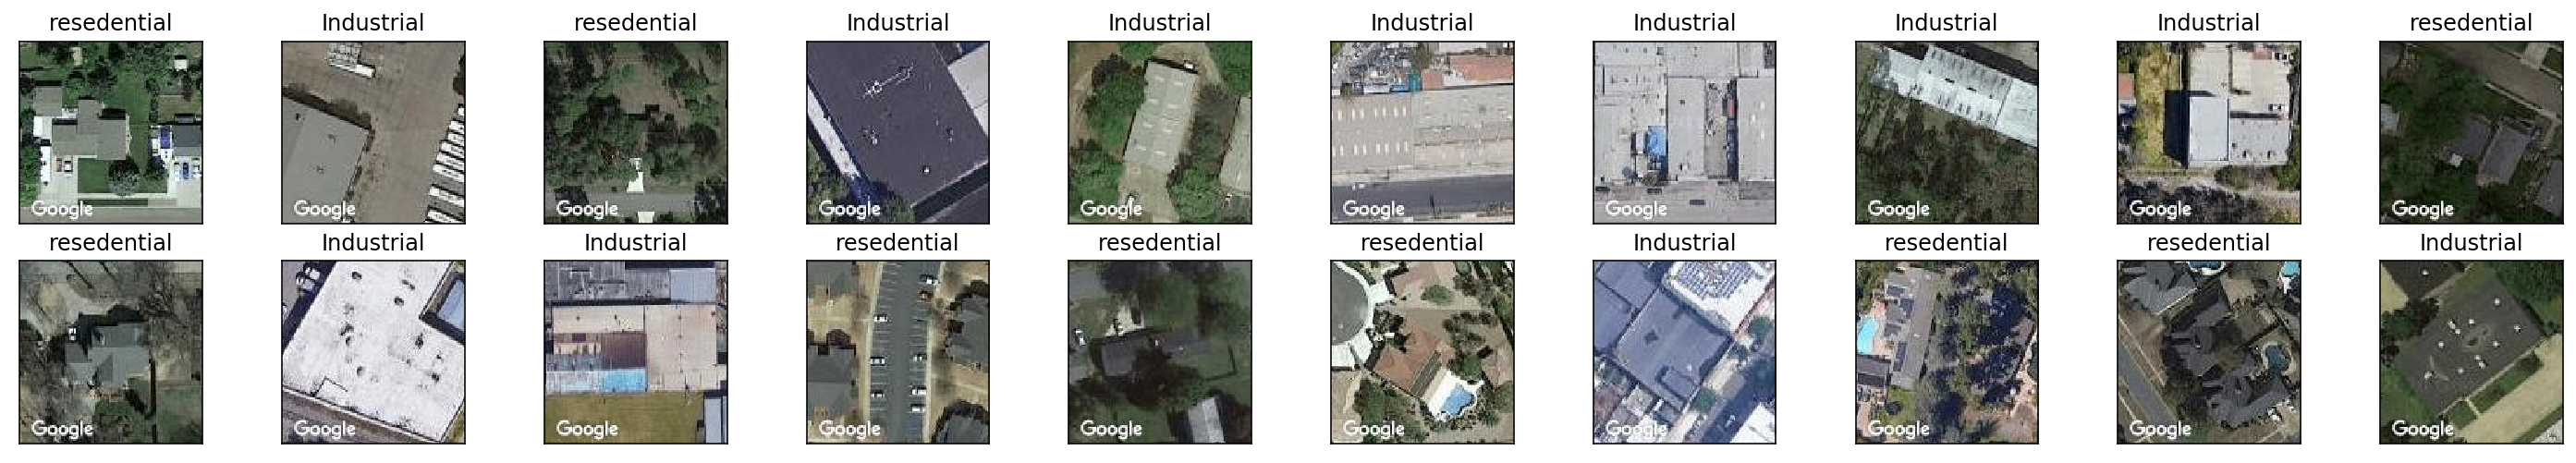

In [39]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [40]:
###Define pretrained model
model=models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [41]:
# Use GPU if it's available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.densenet121(pretrained=True)
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad=False    
# model.classifier=nn.Sequential(nn.Linear(1024, 256),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(256, 12),
#                                  nn.LogSoftmax(dim=1))
model.classifier=nn.Sequential(OrderedDict([
                                ('fc1',nn.Linear(1024, 256)),
                                ('relu',nn.ReLU()),
                                ('dropout',nn.Dropout(0.25)),
                                ('fc2',nn.Linear(256, 64)),
                                ('reul',nn.ReLU()),
                                ('dropout',nn.Dropout(0.25)),
                                ('fc3',nn.Linear(64, 12)),
                                ('output',nn.LogSoftmax(dim=1))
                                ]))
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
# specify loss function (categorical cross-entropy)
criterion=nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
model.to(device);

In [47]:
#Define number of epochs to train the model
num_epochs=30
#Initialize tracker for minimum validation loss
#Set initial "min" to infinity
valid_loss_min=np.Inf 
for epoch in range(num_epochs):
    #Monitor training loss
    train_loss=0.0 
    valid_loss=0.0
    #Define model for training
    model.train()
    #Train the model
    for data,target in train_loader:
        #move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        #1.Clear the gradients of all optimized variables
        optimizer.zero_grad()
        #2.Forward pass:compute predicted outputs by passing inputs to the model
        output=model(data)
        #3.Calculate the loss
        loss=criterion(output,target)
        #4.Backward pass:compute gradient of the loss with respect to model parameters
        loss.backward()
        #5.Perform a single optimization step (parameter update)
        optimizer.step()
        #6.Update running training loss
        train_loss+=loss.item()*data.size(0) 
    #Validate the model 
    #Define model for evaluation
    model.eval() 
    for data,target in valid_loader:
        #move tensors to GPU if CUDA is available
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
        #1.forward pass: compute predicted outputs by passing inputs to the model
        output=model(data)
        #2.calculate the loss
        loss=criterion(output,target)
        #3.update running validation loss 
        valid_loss+=loss.item()*data.size(0)
        
    #To Print training & validation statistics 
    #Calculate average loss over an epoch
    train_loss=train_loss/len(train_loader.sampler)
    #Calculate average loss over an epoch
    valid_loss=train_loss/len(valid_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    #Save model if validation loss has decreased
    if valid_loss<=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(),'staticmap.pt')
        valid_loss_min=valid_loss

Epoch: 1 	Training Loss: 0.247011	Validation Loss: 0.000410
Validation loss decreased (inf --> 0.000410).  Saving model ...
Epoch: 2 	Training Loss: 0.245517	Validation Loss: 0.000407
Validation loss decreased (0.000410 --> 0.000407).  Saving model ...
Epoch: 3 	Training Loss: 0.228526	Validation Loss: 0.000379
Validation loss decreased (0.000407 --> 0.000379).  Saving model ...
Epoch: 4 	Training Loss: 0.202197	Validation Loss: 0.000335
Validation loss decreased (0.000379 --> 0.000335).  Saving model ...
Epoch: 5 	Training Loss: 0.200765	Validation Loss: 0.000333
Validation loss decreased (0.000335 --> 0.000333).  Saving model ...
Epoch: 6 	Training Loss: 0.200395	Validation Loss: 0.000332
Validation loss decreased (0.000333 --> 0.000332).  Saving model ...
Epoch: 7 	Training Loss: 0.208701	Validation Loss: 0.000346
Epoch: 8 	Training Loss: 0.199005	Validation Loss: 0.000330
Validation loss decreased (0.000332 --> 0.000330).  Saving model ...
Epoch: 9 	Training Loss: 0.170881	Validati

In [48]:
model.load_state_dict(torch.load('staticmap.pt'))

<All keys matched successfully>

In [51]:
#Define lists to monitor test loss and accuracy
test_loss=0.0
class_correct=list(0. for i in range(2))
class_total=list(0. for i in range(2))
#Define model for evaluation
model.eval()
for data,target in test_loader:
    #move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    #1.Forward pass:testloadercompute predicted outputs by passing inputs to the model
    output=model(data)
    #2.Calculate the loss
    loss=criterion(output,target)
    #3.Update test loss 
    test_loss+=loss.item()*data.size(0)
    #4.Convert output probabilities to predicted class
    _, pred=torch.max(output,1)
    #5.Compare predictions to true label
    correct=np.squeeze(pred.eq(target.data.view_as(pred)))
    #6.Calculate test accuracy for each object class
    for i in range(len(target)):
        label=target.data[i]
        class_correct[label]+=correct[i].item()
        class_total[label]+=1
# calculate and print avg test loss
test_loss=test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(2):
    if class_total[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%(
            classes[i],100*class_correct[i]/class_total[i],
            np.sum(class_correct[i]),np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)'%(classes[i]))
        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)'%(
    100.*np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),np.sum(class_total)))

Test Loss: 0.335763

Test Accuracy of Industrial: 89% (134/150)
Test Accuracy of resedential: 92% (139/150)

Test Accuracy (Overall): 91% (273/300)


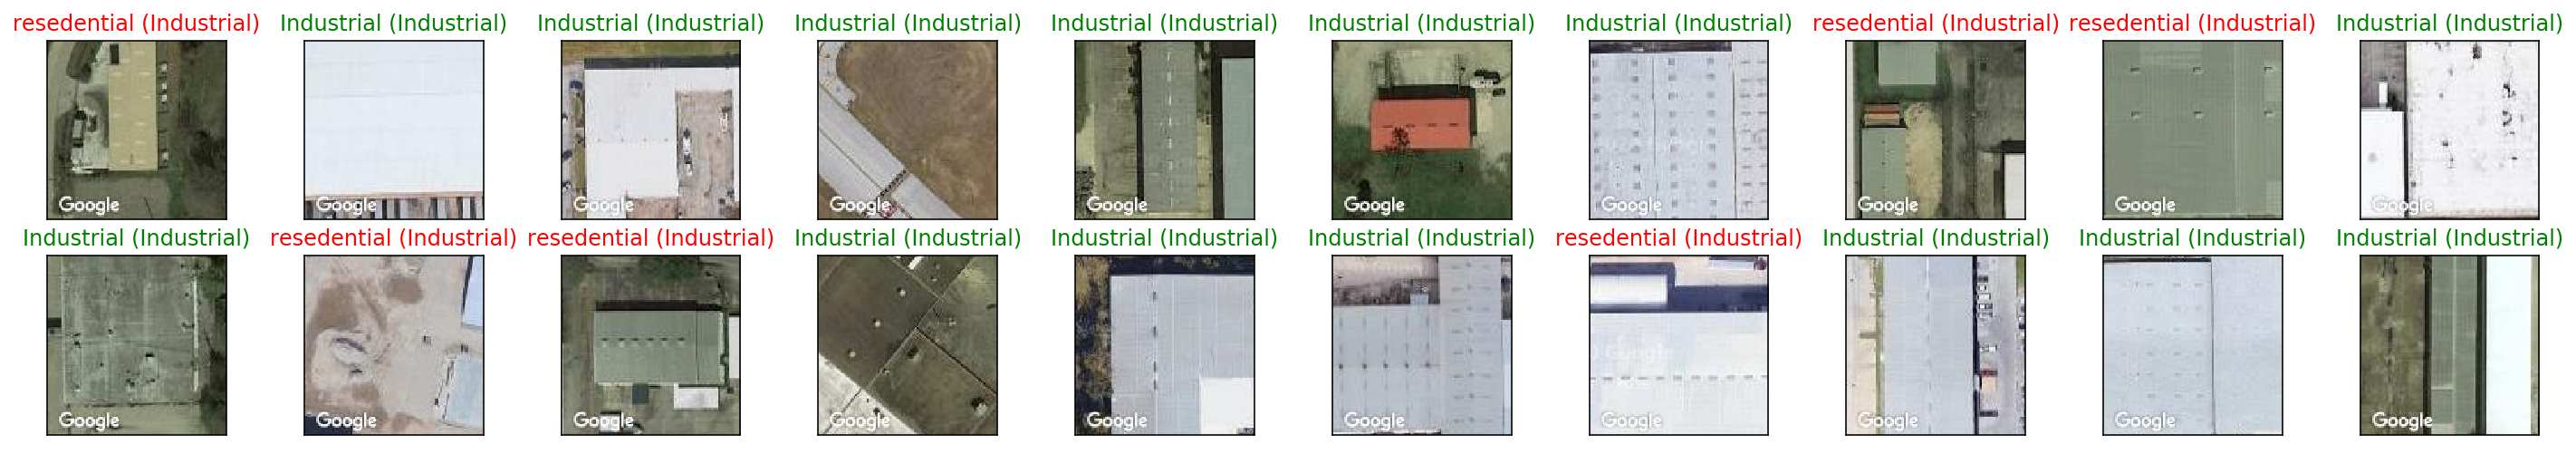

In [52]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))